This is a simple diffusion model on olivetti faces  from scratch in pytorch

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from .autonotebook import tqdm as notebook_tqdm
#set the numpy random seed
np.random.seed(1234)

In [6]:
data = datasets.fetch_olivetti_faces()
data_oliv = pd.DataFrame(data.data)
data_num = data_oliv.to_numpy()
data_oliv.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.665289,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.136364,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.074380,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.652893,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.190083,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554


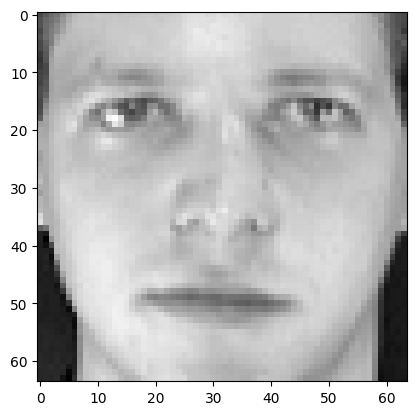

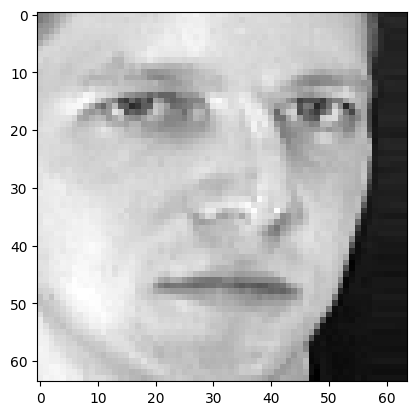

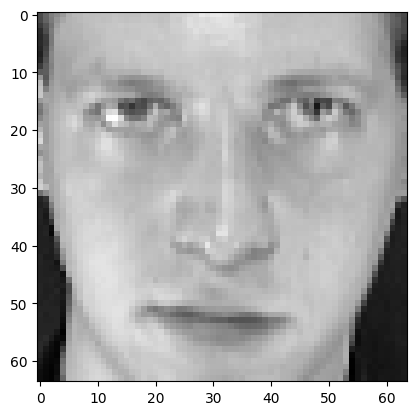

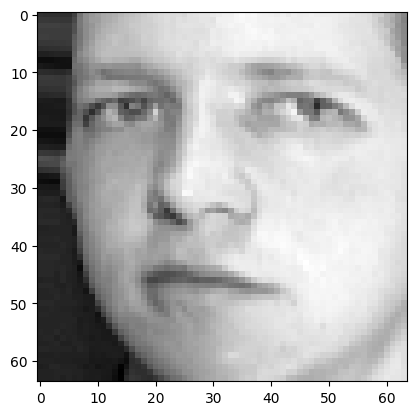

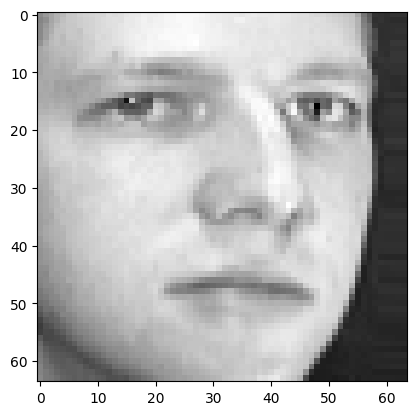

In [8]:
#lets visualize the images

import matplotlib.pyplot as plt
import numpy as np

def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

for i in range(5):
    show_image(data_num[i,:].reshape(64,64))

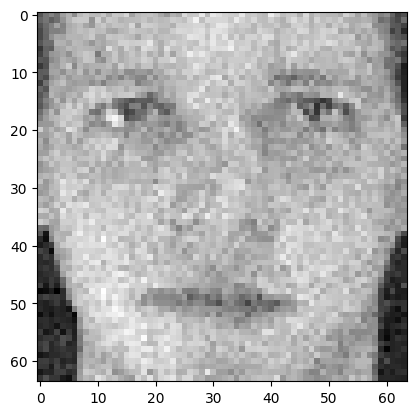

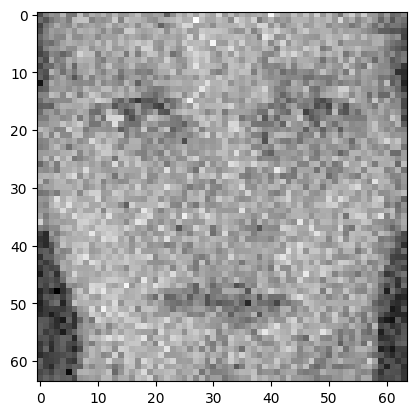

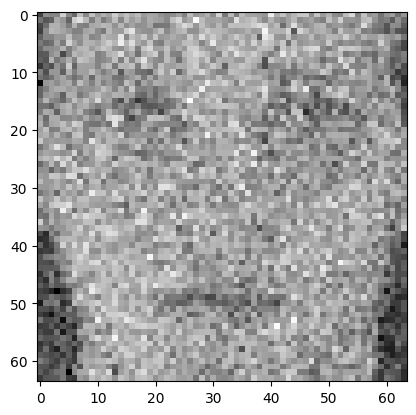

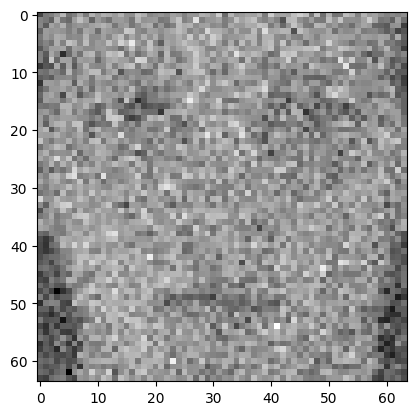

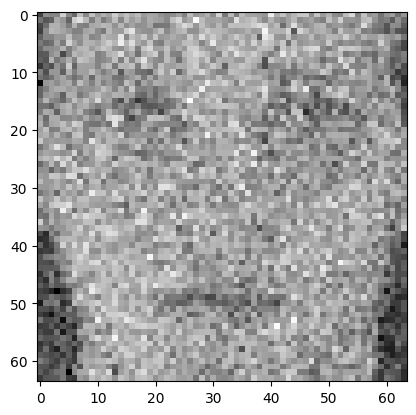

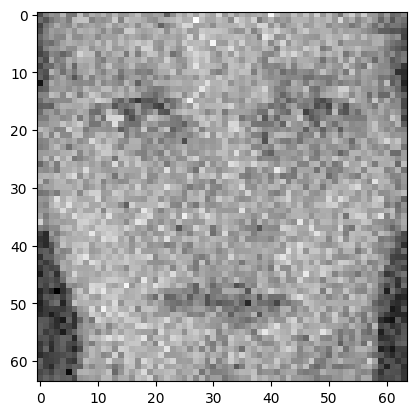

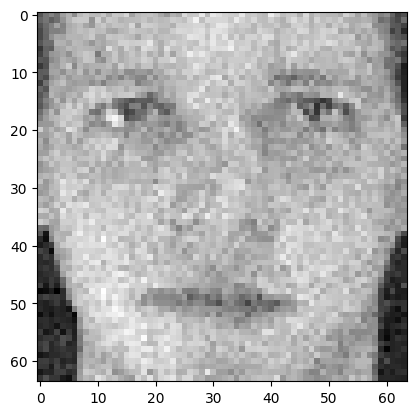

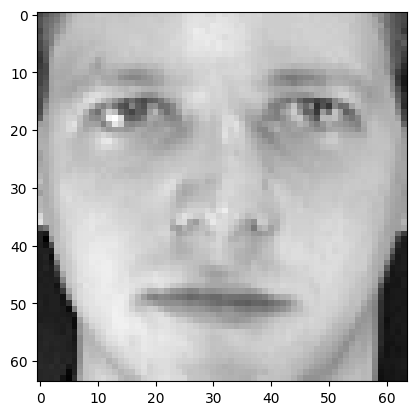

In [15]:
#lets add the gaussian noise to the images
#beta be 100 values between 0.1 and 0.2

beta = np.linspace(0.1, 0.9, 4)
Noise = []

data_img = data_num[0,:]

for i in range(len(beta)):
    mean = data_img*(1-beta[i])**(1/2)
    std = beta[i]
    noise = np.random.normal(mean, std, 4096)
    Noise.append([noise])
    data_noise = data_img + noise
    data_img = data_noise
    show_image(data_noise.reshape(64,64))


fin_imag = data_noise

#reverse the process

for i in range(len(beta)):
    data_noise = fin_imag - Noise[len(beta)-i-1]
    fin_imag = data_noise
    show_image(data_noise.reshape(64, 64))


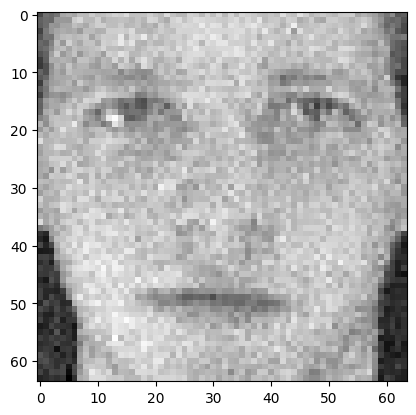

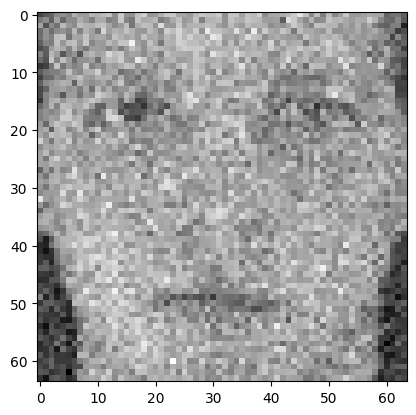

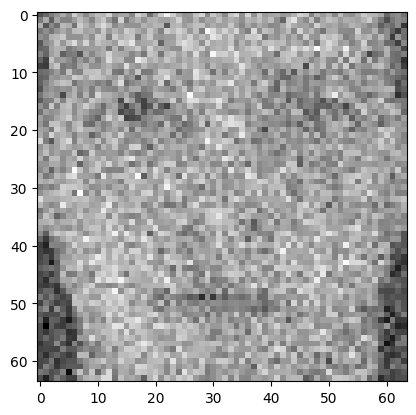

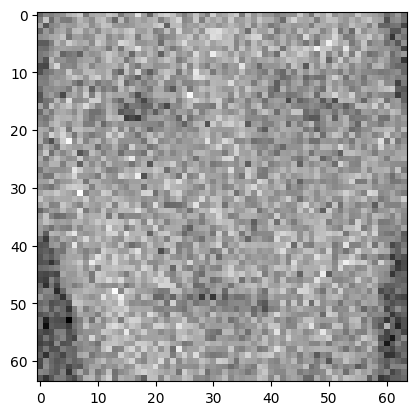

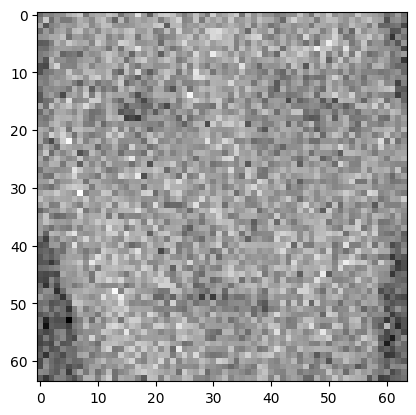

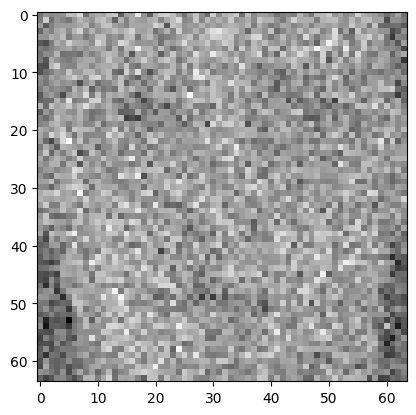

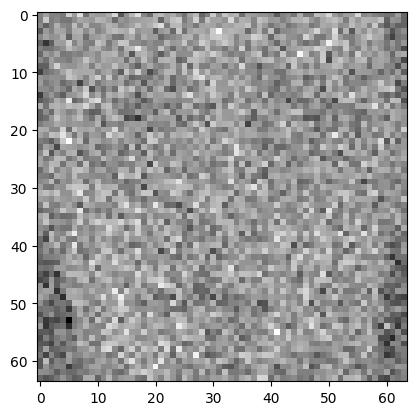

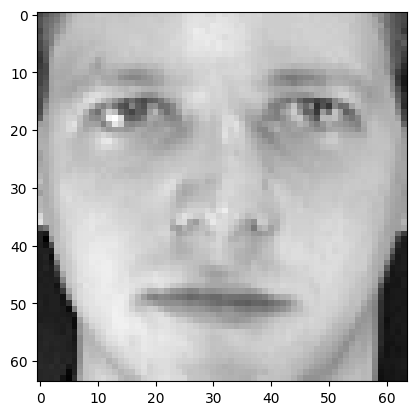

In [ ]:
#lets add the gaussian noise to the images
#beta be 100 values between 0.1 and 0.2

beta = np.linspace(0.1, 0.9, 4)
Noise = []

data_img = data_num[0, :]

for i in range(len(beta)):
    mean = data_img*(1-beta[i])**(1/2)
    std = beta[i]
    noise = np.random.normal(mean, std, 4096)
    Noise.append([noise])
    data_noise = data_img + noise
    data_img = data_noise
    show_image(data_noise.reshape(64, 64))


fin_imag = data_noise

#reverse the process

for i in range(len(beta)):
    data_noise = fin_imag - Noise[i]
    fin_imag = data_noise
    show_image(data_noise.reshape(64, 64))


0


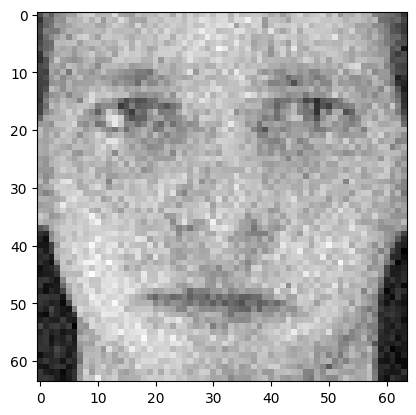

1


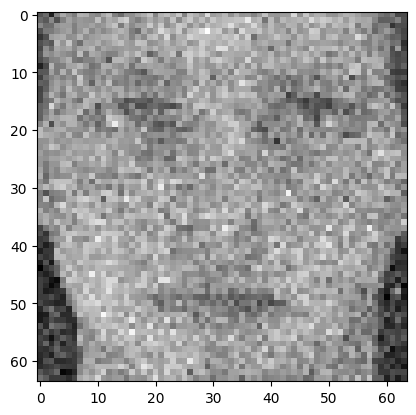

2


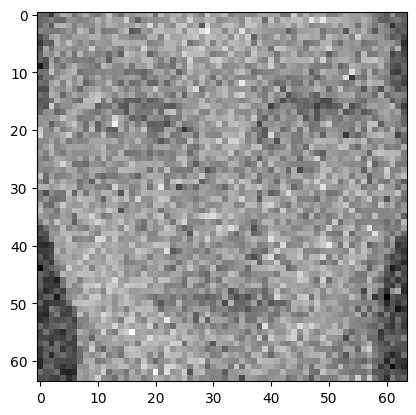

3


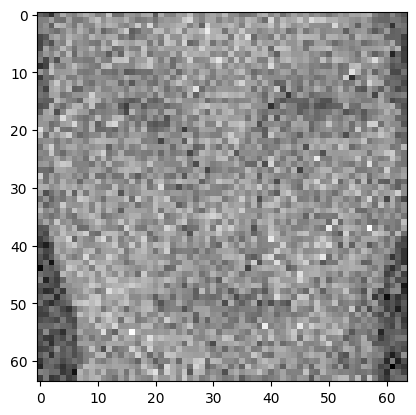

3


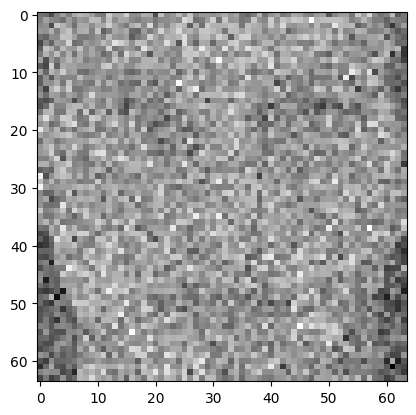

2


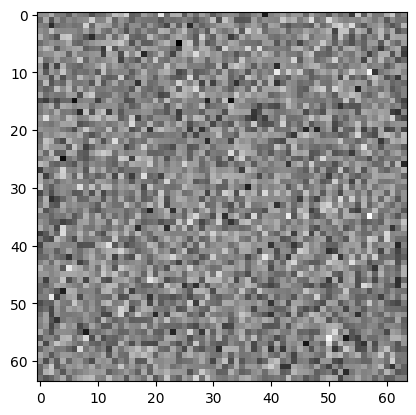

1


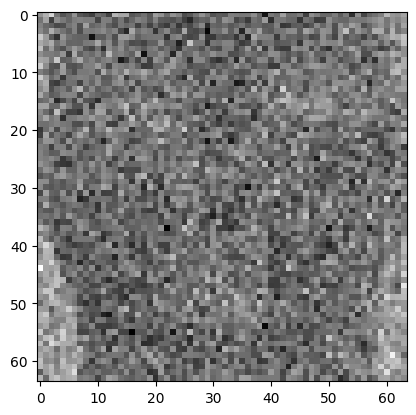

0


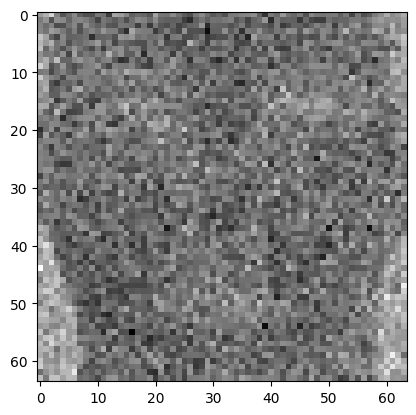

In [21]:
data = datasets.fetch_olivetti_faces()
data_oliv = pd.DataFrame(data.data)
data_num = data_oliv.to_numpy()
data_oliv.head()
#lets add the gaussian noise to the images
#beta be 100 values between 0.1 and 0.2

beta = np.linspace(0.1, 0.9, 4)

Noise = []

data_img = data_num[0, :]

for i in range(len(beta)):
    mean = data_img*(1-beta[i])**(1/2)
    std = beta[i]
    noise = np.random.normal(mean, std, 4096)
    Noise.append([noise])
    data_noise = data_img + noise
    data_img = data_noise
    print(i)
    show_image(data_noise.reshape(64, 64))


fin_imag = data_noise

#reverse the process

for i in range(len(beta)):
    mean = data_img*(1-beta[len(beta)-1-i])**(1/2)
    std = beta[len(beta)-1-i]
    noise = np.random.normal(mean, std, 4096)
    data_noise = fin_imag - noise
    fin_imag = data_noise
    print(len(beta)-1-i)
    show_image(data_noise.reshape(64, 64))


In [22]:
#sum all the columns of the data
new_noise = np.sum(Noise, axis=0)
new_noise


array([[ 1.81364296,  0.95960123, -1.1255585 , ...,  2.12712958,
         2.74758829,  2.82872359]])

In [23]:
#Lets build a simple unet model, input we pass is a 1d array of 4096 values and output is also a 1d array of 4096 values

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class UNet(nn.Module):

    def __init__(self):
        super(UNet, self).__init__()

        #downsampling path
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=3, padding=1)

        #upsampling path
        self.conv5 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.conv6 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.conv7 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv8 = nn.ConvTranspose2d(
            in_channels=64, out_channels=1, kernel_size=3,padding=1)
        
        

    def forward(self, x):

        #downsampling path
        x1 = F.selu(self.conv1(x))
        x2 = F.selu(self.conv2(x1))
        x3 = F.selu(self.conv3(x2))
        x4 = F.selu(self.conv4(x3))

        #upsampling path
        x5 = F.selu(self.conv5(x4))
        x6 = F.selu(self.conv6(x5))
        x7 = F.selu(self.conv7(x6))
        #softmax activation
        out = F.selu(self.conv8(x7))

        return out

    

#lets create a model object

model = UNet()

#lets see the model summary

summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
            Conv2d-2          [-1, 128, 64, 64]          73,856
            Conv2d-3          [-1, 256, 64, 64]         295,168
            Conv2d-4          [-1, 512, 64, 64]       1,180,160
   ConvTranspose2d-5        [-1, 256, 128, 128]         524,544
   ConvTranspose2d-6        [-1, 128, 256, 256]         131,200
   ConvTranspose2d-7         [-1, 64, 512, 512]         131,136
   ConvTranspose2d-8          [-1, 1, 512, 512]             577
Total params: 2,337,281
Trainable params: 2,337,281
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 256.00
Params size (MB): 8.92
Estimated Total Size (MB): 264.93
----------------------------------------------------------------


In [24]:
#lets create a loss function and optimizer

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#lets convert the data to tensors
data_num = data_num[12, :]



#lets convert the data to tensors
data_num = torch.from_numpy(data_num).float()

#lets reshape the data into 4d array
data_num = data_num.reshape(1, 1, 64, 64)

#lets convert the data to tensors
new_noise = torch.from_numpy(new_noise).float()

#lets reshape the data into 4d array
new_noise = new_noise.reshape(1, 1, 64, 64)

#lets convert the data to tensors
fin_imag = torch.from_numpy(fin_imag).float()

#lets reshape the data into 4d array
fin_imag = fin_imag.reshape(1, 1, 64, 64)

#lets train the model

epochs = 100
batch_size = 4

for i in range(len(beta)):

    for epoch in range(epochs):

        #forward pass
        output = model(fin_imag)
        output = torch.nn.functional.interpolate(
            output, size=(64, 64), mode='bilinear', align_corners=False)

        #calculate loss
        std = beta[len(beta)-1-i]
        mean = output
        noise = torch.normal(mean, std)
        
        loss = criterion(noise, new_noise)

        #backward pass
        loss.backward()

        #update weights
        optimizer.step()

        #zero the gradients
        optimizer.zero_grad()

        print(f'epoch: {epoch+1}, loss: {loss.item():.4f}')
        if (loss < 5):
            output = output.detach().numpy()
            show_image(output.reshape(64, 64))
    

#lets see the output
if (loss > 2):
    output = output.detach().numpy()

epoch: 1, loss: 19.9700
epoch: 2, loss: 19.9127
epoch: 3, loss: 19.9701
epoch: 4, loss: 19.9477
epoch: 5, loss: 19.7819
epoch: 6, loss: 20.1116
epoch: 7, loss: 20.2657
epoch: 8, loss: 19.9868
epoch: 9, loss: 20.0536
epoch: 10, loss: 19.9212
epoch: 11, loss: 19.7934
epoch: 12, loss: 19.8612
epoch: 13, loss: 19.8897
epoch: 14, loss: 20.0872
epoch: 15, loss: 19.8237
epoch: 16, loss: 20.0508
epoch: 17, loss: 19.7502
epoch: 18, loss: 20.0813
epoch: 19, loss: 20.1929
epoch: 20, loss: 20.1379
epoch: 21, loss: 20.1426
epoch: 22, loss: 19.8737
epoch: 23, loss: 20.1294
epoch: 24, loss: 20.0651
epoch: 25, loss: 19.8349
epoch: 26, loss: 20.0854
epoch: 27, loss: 20.0314
epoch: 28, loss: 20.0596
epoch: 29, loss: 20.1396
epoch: 30, loss: 20.0942
epoch: 31, loss: 20.1212
epoch: 32, loss: 19.9664
epoch: 33, loss: 19.9683
epoch: 34, loss: 20.1757
epoch: 35, loss: 20.1231
epoch: 36, loss: 20.2739
epoch: 37, loss: 20.0225
epoch: 38, loss: 20.1648
epoch: 39, loss: 20.0894
epoch: 40, loss: 20.1219
epoch: 41

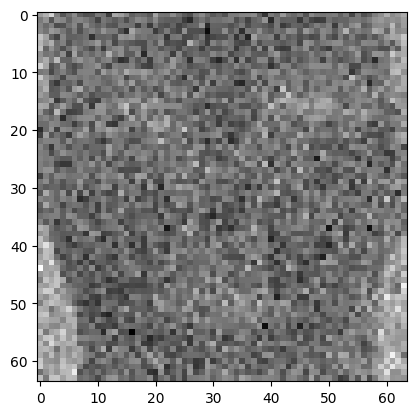

In [25]:
img = fin_imag-output
show_image(img.reshape(64, 64))

In [26]:
output

array([[[[-0.18486345, -0.0935522 , -0.05317733, ..., -0.1692351 ,
          -0.22592682, -0.19532558],
         [ 0.00551268, -0.05901142, -0.23764974, ..., -0.26760817,
          -0.00915247, -0.2067003 ],
         [ 0.00244075,  0.1440692 ,  0.12361383, ..., -0.20992018,
          -0.1024837 , -0.19324122],
         ...,
         [-0.04669272,  0.04760616, -0.24560322, ..., -0.20526342,
          -0.04553287, -0.52322215],
         [-0.2592754 , -0.27511907, -0.4725859 , ...,  0.04151233,
          -0.12563421, -0.2448194 ],
         [-0.24522667, -0.10767495, -0.36108854, ..., -0.3066241 ,
          -0.02440131, -0.47749966]]]], dtype=float32)

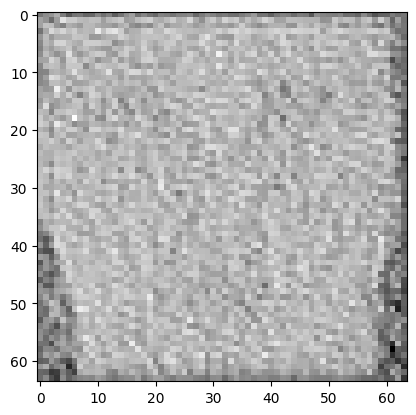

In [27]:
show_image(output.reshape(64, 64))